# **Results Analysis for Melanoma Detection (Multiclass and Binary Evaluation)**

The aim of this notebook is to provide a structured analysis of the results obtained with several deep learning models for skin lesion classification. Rather than focusing on training, we evaluate and compare previously trained models using both a multiclass setting (melanoma, nevus, and seborrheic keratosis) and a binary clinical setting (melanoma vs non-melanoma).

### **Author:** Mario Líndez Martínez

---

# **Libraries**

In [ ]:
# Install and upgrade fastai and related libraries
!pip install -U "fastai==2.7.15" "fastcore==1.5.29" "fastprogress==1.0.3" "fastdownload==0.0.7"

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6

In [ ]:
import os
from google.colab import files
from fastai.vision.all import *
from pathlib import Path
import timm

# **Dataset Preparing**

## **Download**

To download the file and ensure no time is wasted, we decided to use Google Gemini to build a pipeline for downloading the dataset:

**You are an expert in Kaggle, datasets, deep learning and python. I need a pipeline to be able to download a dataset from Kaggle. You need to include flags to avoid downloading the dataset every time the cell is executed, as well as oher security flags. Manage resources in a way the access to the dataset is fast.**

---

<br>

After a few minor changes, we obtained an excellent pipeline to obtain the dataset without the need to download every time the cell is executed. This is only necessary when the environment is changed.

The authentication with Kaggle is carried out through the upload of a JSON file generated from the person's personal account. Once the file is uploaded, the zip containing the dataset will be downloaded, then unzipped and deleted.

Everything is managed in dymanic memory, so it is necessary to activate **High RAM Capacity** when selecting the environment.

In [ ]:
# --- 1. CONFIGURACIÓN DE KAGGLE API ---
kaggle_json_path = os.path.expanduser("~/.config/kaggle/kaggle.json")
token_setup_successful = False

# Verificar si kaggle.json ya existe
if not os.path.exists(kaggle_json_path):
    print("⬇️ Token no encontrado. Sube tu archivo kaggle.json ⬇️")
    uploaded = files.upload() # files.upload() returns a dict of uploaded files

    if 'kaggle.json' in uploaded:
        # Crear la carpeta oculta si no existe
        !mkdir -p ~/.config/kaggle
        # Mover el archivo json ahí dentro
        !mv kaggle.json ~/.config/kaggle/ # Usamos mv para evitar dejar una copia en /content
        # Dar los permisos de seguridad (lectura/escritura solo para ti)
        !chmod 600 ~/.config/kaggle/kaggle.json
        print("✅ Configuración completada: Fichero movido a ~/.config/kaggle/")
        token_setup_successful = True

        !pip install kaggle --quiet
        !kaggle --version
        from kaggle.api.kaggle_api_extended import KaggleApi
    else:
        print("❌ No se subió el archivo kaggle.json. Asegúrate de subirlo para continuar.")
else:
    print("✅ kaggle.json ya existe en ~/.config/kaggle/. Saltando la subida.")
    token_setup_successful = True

# Proceder con la autenticación y descarga solo si el token se configuró correctamente
if token_setup_successful:
    try:
        # Inicializamos la API (esto debe hacerse siempre para asegurar que la API está autenticada)
        # La API buscará automáticamente el archivo kaggle.json en ~/.config/kaggle/
        api = KaggleApi()
        api.authenticate()
        print("✅ Autenticación con Kaggle API exitosa.")

        # --- 2. DESCARGA DEL DATASET ---
        dataset_path = '/content/dataset'

        # Verificar si el dataset ya está descargado y descomprimido
        # Comprobamos si la carpeta existe y si contiene archivos
        if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
            print("⏳ Descargando dataset en /content/dataset...")
            api.dataset_download_files(
                'wanderdust/skin-lesion-analysis-toward-melanoma-detection',
                path=dataset_path,
                unzip=True,
                quiet=False
            )
            print("✅ ¡Descarga finalizada!")

            # Borrar el archivo zip descargado para ahorrar espacio
            print("🧹 Limpiando archivos zip...")
            for file in os.listdir(dataset_path):
                if file.endswith(".zip"):
                    os.remove(os.path.join(dataset_path, file))
            print("✅ Archivo zip eliminado correctamente.")
        else:
            print("✅ Dataset ya descargado y descomprimido en /content/dataset/. Saltando la descarga.")
    except Exception as e:
        print(f"❌ Error durante la autenticación o descarga del dataset: {e}")
else:
    print("⚠️ No se puede proceder con la autenticación o descarga del dataset sin un archivo kaggle.json válido.")

⬇️ Token no encontrado. Sube tu archivo kaggle.json ⬇️


Saving kaggle.json to kaggle.json
✅ Configuración completada: Fichero movido a ~/.config/kaggle/
Kaggle API 1.7.4.5
✅ Autenticación con Kaggle API exitosa.
⏳ Descargando dataset en /content/dataset...
Dataset URL: https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection


100%|██████████| 11.3G/11.3G [00:27<00:00, 442MB/s]



✅ ¡Descarga finalizada!
🧹 Limpiando archivos zip...
✅ Archivo zip eliminado correctamente.


## **Creation of the Datablock**

In [ ]:
!ls -lha
!ls /content/dataset/skin-lesions/

total 20K
drwxr-xr-x 1 root root 4.0K Jan 16 02:22 .
drwxr-xr-x 1 root root 4.0K Jan 16 02:08 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Jan 16 02:24 dataset
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
test  train  valid


In [ ]:
path = Path("/content/dataset/skin-lesions")
train_path = path/'train'
valid_path = path/'valid'
test_path  = path/'test'

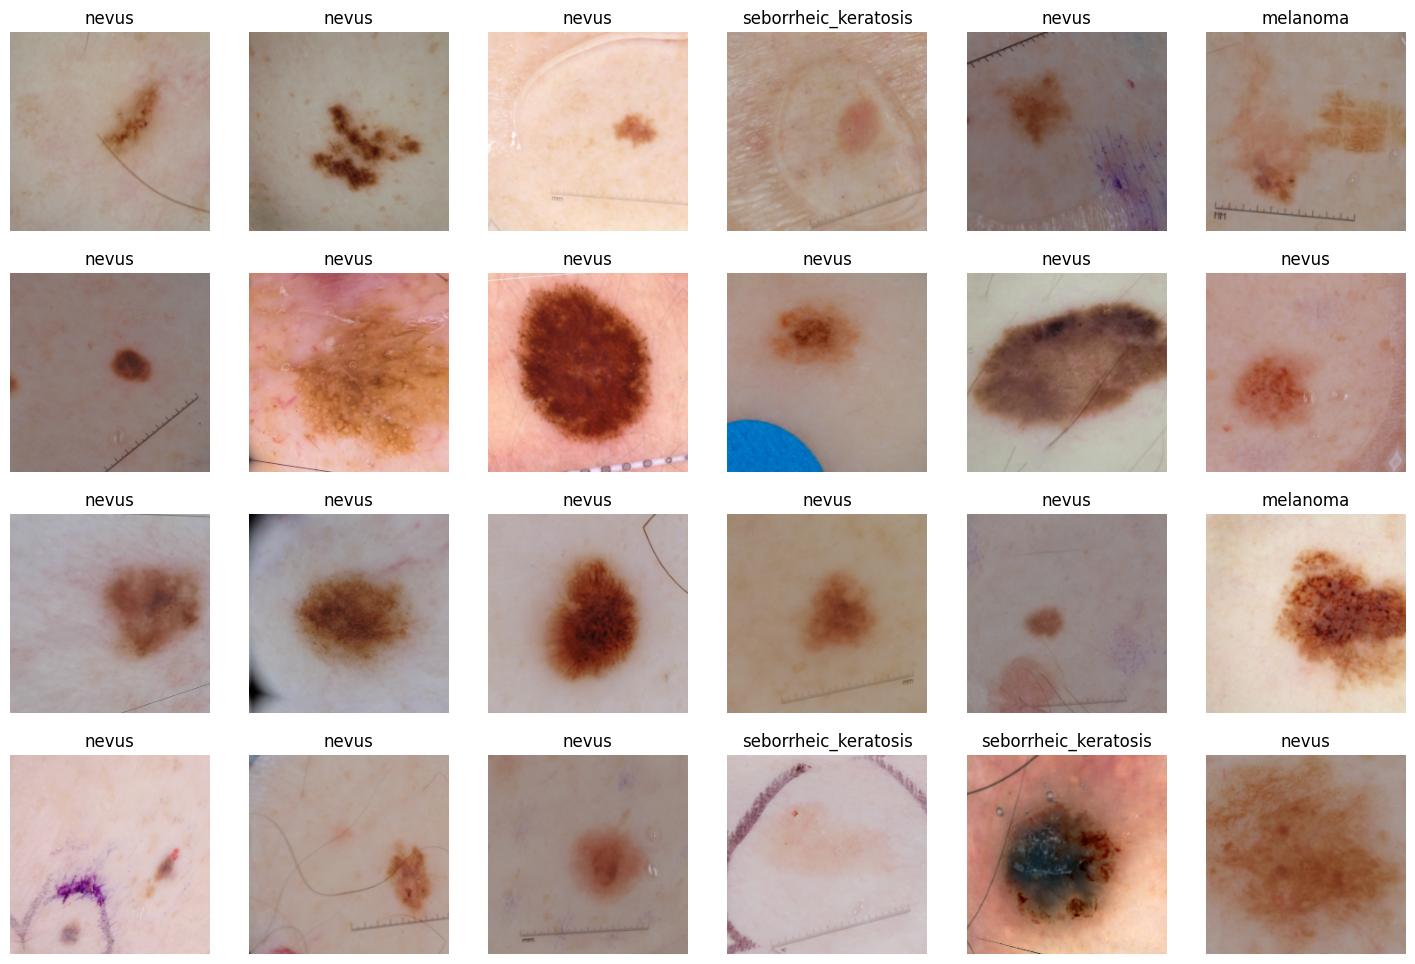

In [ ]:
dtblk = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(do_flip=True, max_rotate=10, max_lighting=0.2),
        Normalize.from_stats(*imagenet_stats)
    ]
)

dls=dtblk.dataloaders(path,bs=128)

dls.show_batch(max_n=24)

# Model Loading

We will load the previously trained models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
PROJECT_PATH = Path("/content/drive/My Drive/Colab Notebooks/VisionPorComputador/PROYECTO FINAL/")

MODEL_PATHS = {
    "ViT_supervised":     Path(PROJECT_PATH/"vit_supervised.pkl"),
    "ViT_DINO_semi":      Path(PROJECT_PATH/"vit_semi_supervised.pkl"),
    "EfficientNet_TL":    Path(PROJECT_PATH/"EfficientNet_TL_DEF.pkl"),
    "InceptionResNet_TL": Path(PROJECT_PATH/"Inception_ResNet_v2_TL.pkl"),
}

In [ ]:
import dill

learners = {}
for name, p in MODEL_PATHS.items():
    print(f"Cargando {name} -> {p}")
    learners[name] = load_learner(p, cpu=False, pickle_module=dill)
    print("/t vocab:", list(learners[name].dls.vocab))

Cargando ViT_supervised -> /content/drive/My Drive/Colab Notebooks/VisionPorComputador/PROYECTO FINAL/vit_supervised.pkl
/t vocab: ['melanoma', 'nevus', 'seborrheic_keratosis']
Cargando ViT_DINO_semi -> /content/drive/My Drive/Colab Notebooks/VisionPorComputador/PROYECTO FINAL/vit_semi_supervised.pkl
/t vocab: ['melanoma', 'nevus', 'seborrheic_keratosis']
Cargando EfficientNet_TL -> /content/drive/My Drive/Colab Notebooks/VisionPorComputador/PROYECTO FINAL/EfficientNet_TL_DEF.pkl
/t vocab: ['melanoma', 'nevus', 'seborrheic_keratosis']
Cargando InceptionResNet_TL -> /content/drive/My Drive/Colab Notebooks/VisionPorComputador/PROYECTO FINAL/Inception_ResNet_v2_TL.pkl
/t vocab: ['melanoma', 'nevus', 'seborrheic_keratosis']


Since the models were built using different versions of fastai, we need to make them all compatible with the version used in this notebook. To do this, we will patch the problematic models.

In [ ]:
from timm.models.vision_transformer import Attention

def patch_attn_dim_in_vit(learn):
    patched = 0
    for m in learn.model.modules():
        if isinstance(m, Attention) and not hasattr(m, "attn_dim"):
            # En ViT, attn_dim suele ser el dim del embedding (num_heads * head_dim)
            if hasattr(m, "qkv") and hasattr(m.qkv, "out_features"):
                m.attn_dim = m.qkv.out_features // 3  # qkv produce 3*dim
            elif hasattr(m, "num_heads") and hasattr(m, "head_dim"):
                m.attn_dim = m.num_heads * m.head_dim
            elif hasattr(m, "proj") and hasattr(m.proj, "in_features"):
                m.attn_dim = m.proj.in_features
            else:
                raise RuntimeError("No puedo inferir attn_dim para este Attention.")
            patched += 1
    return patched

In [ ]:
n = patch_attn_dim_in_vit(learners["ViT_supervised"])
print("Attention parcheados:", n)

Attention parcheados: 12


In [ ]:
n = patch_attn_dim_in_vit(learners["ViT_DINO_semi"])
print("Attention parcheados:", n)

Attention parcheados: 12


# Predictions

Once the models are correctly loaded, we will compute the predictions for the test set.

In [ ]:
from fastai.vision.all import get_image_files

In [ ]:
test_files = sorted(get_image_files(test_path))
print("Test images:", len(test_files))

Test images: 600


This dataset contains 600 test images in total: 117 melanomas, 393 nevi, and 90 seborrheic keratoses.

In [ ]:
import torch, numpy as np
from pathlib import Path

DEVICE = torch.device("cuda")

def targs_from_folders(files, vocab):
    o2i = {c:i for i,c in enumerate(vocab)}
    return np.array([o2i[Path(f).parent.name] for f in files], dtype=np.int64)

def safe_get_test_preds(learn, test_files, vocab, device=DEVICE):
    learn.model.to(device)

    dl = learn.dls.test_dl(
        test_files,
        with_labels=False,
        device=device,
        num_workers=0,          # <-- clave
        persistent_workers=False
    )

    preds = learn.get_preds(dl=dl)[0]       # solo preds
    targs = targs_from_folders(test_files, vocab)
    return preds.cpu().numpy(), targs


In [ ]:
all_preds = {}
all_targs = None

VOCAB = list(next(iter(learners.values())).dls.vocab)

for name, learn in learners.items():
    print("============\t" + name + "\t============")
    preds, targs = safe_get_test_preds(learn, test_files, VOCAB)
    all_preds[name] = preds
    all_targs = targs if all_targs is None else all_targs
    print(name, preds.shape)
    print("\n")

# sanity: mismos targs para todos
print("targs shape:", all_targs.shape)


============	ViT_supervised	============


ViT_supervised (600, 3)


============	ViT_DINO_semi	============


ViT_DINO_semi (600, 3)


============	EfficientNet_TL	============


EfficientNet_TL (600, 3)


============	InceptionResNet_TL	============


InceptionResNet_TL (600, 3)


targs shape: (600,)


# Results Analysis

## Multiclass analysis

The confusion matrix is a table that summarizes how a classifier behaves by comparing, for each image in the test set, the true class with the class predicted by the model. The rows correspond to the true classes, while the columns correspond to the predicted classes.

It is very useful because it does not only provide a single global measure, but also shows which types of errors the model makes. In addition, it allows us to identify systematic confusions between classes.

Besides this matrix, we will use the following set of metrics to evaluate each model in a general way:
* Accuracy: Overall proportion of correct predictions. It provides a global view of performance.
* Precision: Among all predictions assigned to a class, the fraction that is correct. It can be interpreted as control of false positives for that class: the lower it is, the more often the model assigns that class when it should not.
* Recall: Among all real examples of a class, the fraction that the model detects. It can be interpreted as control of false negatives: the lower it is, the more real cases of that class are missed.
* Per-class F1-score: Harmonic mean of precision and recall. It summarizes the balance between false positives and false negatives; it decreases when one of the two (or both) is low.
* Macro average: Average of the metric giving the same weight to each class. It can be interpreted as the mean “per-class” performance, useful to assess whether the model treats all classes in a balanced way.
* Weighted average: Average weighted by the support (number of samples) of each class. It can be interpreted as the overall average performance considering the true class distribution; it is usually dominated by the most frequent classes.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

mel_idx = VOCAB.index("melanoma")

def plot_cm_from_preds(preds, targs, vocab, title="", figsize=(5,5), dpi=120):
    y_pred = preds.argmax(axis=1)
    cm = confusion_matrix(targs, y_pred, labels=list(range(len(vocab))))
    acc = (y_pred == targs).mean()

    plt.figure(figsize=figsize, dpi=dpi)
    disp = ConfusionMatrixDisplay(cm, display_labels=vocab)
    disp.plot(values_format='d', xticks_rotation=25)
    plt.title(f"{title} | acc={acc*100:.2f}%")
    plt.show()
    return cm, acc



=== ViT_supervised ===


<Figure size 600x600 with 0 Axes>

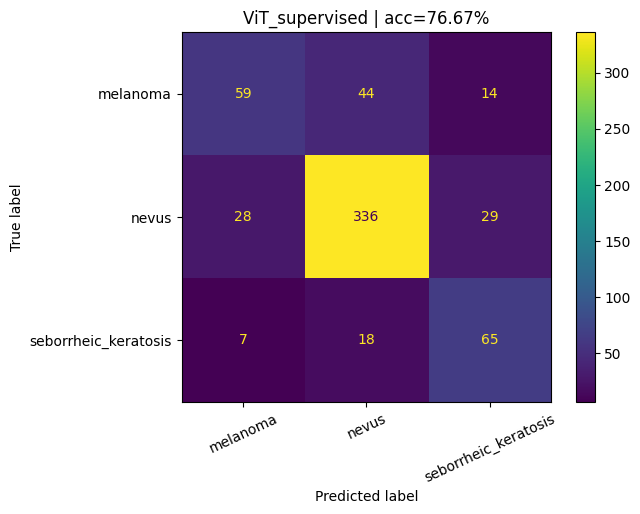

                      precision    recall  f1-score   support

            melanoma     0.6277    0.5043    0.5592       117
               nevus     0.8442    0.8550    0.8496       393
seborrheic_keratosis     0.6019    0.7222    0.6566        90

            accuracy                         0.7667       600
           macro avg     0.6912    0.6938    0.6885       600
        weighted avg     0.7656    0.7667    0.7640       600



In [ ]:
print("\n=== ViT_supervised ===")
cm, acc = plot_cm_from_preds(all_preds['ViT_supervised'], all_targs, VOCAB, title='ViT_supervised', figsize=(5,5))

yhat = all_preds['ViT_supervised'].argmax(axis=1)
print(classification_report(all_targs, yhat, target_names=VOCAB, digits=4))

The ViT_supervised model achieves an accuracy of 76.67%, with a clearly uneven performance across classes according to the confusion matrix and the classification report.

The nevus class is the best recognized, with precision 0.844 and recall 0.855 (F1=0.850), indicating consistent and stable predictions on the majority class.

For seborrheic_keratosis, the model maintains a recall of 0.722 but a lower precision of 0.602 (F1=0.657). This suggests that, although it retrieves a good portion of the real cases in this class, it also produces a noticeable number of incorrect assignments to it.

The weakest point is melanoma, with recall 0.504 and precision 0.628 (F1=0.559): roughly half of the melanomas are classified correctly, while the rest are mainly confused with nevus, reflecting insufficient sensitivity for the clinically most critical class.

This gap between classes is also reflected in the averages: the macro average (F1=0.689) is lower than the weighted average (F1=0.764), showing that the overall performance is influenced by the most frequent class and that melanoma performance limits the model's overall quality.


=== ViT_DINO_semi ===


<Figure size 600x600 with 0 Axes>

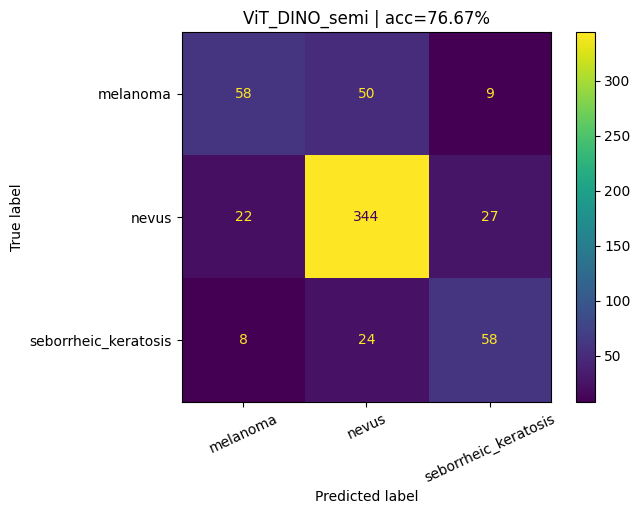

                      precision    recall  f1-score   support

            melanoma     0.6591    0.4957    0.5659       117
               nevus     0.8230    0.8753    0.8483       393
seborrheic_keratosis     0.6170    0.6444    0.6304        90

            accuracy                         0.7667       600
           macro avg     0.6997    0.6718    0.6815       600
        weighted avg     0.7601    0.7667    0.7606       600



In [ ]:
print("\n=== ViT_DINO_semi ===")
cm, acc = plot_cm_from_preds(all_preds['ViT_DINO_semi'], all_targs, VOCAB, title='ViT_DINO_semi', figsize=(5,5))

yhat = all_preds['ViT_DINO_semi'].argmax(axis=1)
print(classification_report(all_targs, yhat, target_names=VOCAB, digits=4))

The ViT_DINO_semi model achieves an accuracy of 76.67% and, similarly to the previous one, shows an uneven performance across classes.

The nevus class is the most solid, with precision 0.8230 and recall 0.8753 (F1 0.8483). This is consistent with the confusion matrix: 344/393 nevi are correctly classified, while the remaining cases are split between melanoma (22) and seborrheic_keratosis (27).

For seborrheic_keratosis, performance is more moderate, with precision 0.6170 and recall 0.6444 (F1 0.6304). The confusion matrix shows 58/90 correct predictions, with most errors going to nevus (24) and fewer to melanoma (8).

The most critical point remains melanoma, with recall 0.4957 and precision 0.6591 (F1 0.5659): only 58/117 melanomas are correctly identified, while the dominant error is still melanoma → nevus (50) (with 9 cases predicted as seborrheic_keratosis), which limits performance on the clinically most relevant class.

The averages reinforce this interpretation: the macro average (F1 0.6815) is below the weighted average (F1 0.7606), indicating that overall performance is influenced by the majority class distribution and that minority classes—especially melanoma—reduce the mean per-class performance.


=== EfficientNet_TL ===


<Figure size 600x600 with 0 Axes>

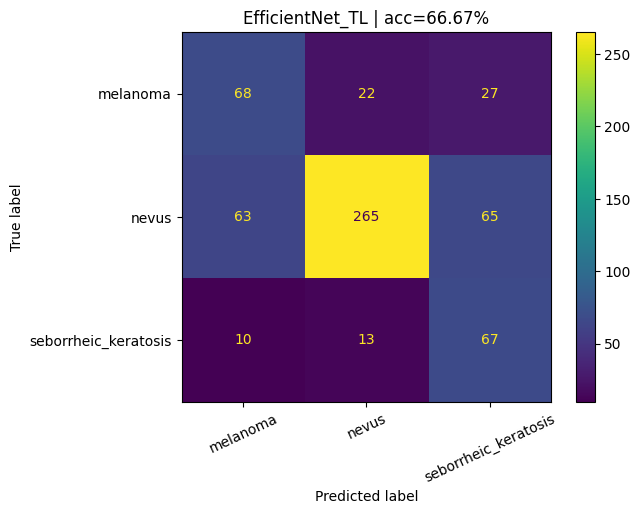

                      precision    recall  f1-score   support

            melanoma     0.4823    0.5812    0.5271       117
               nevus     0.8833    0.6743    0.7648       393
seborrheic_keratosis     0.4214    0.7444    0.5382        90

            accuracy                         0.6667       600
           macro avg     0.5957    0.6666    0.6100       600
        weighted avg     0.7358    0.6667    0.6845       600



In [ ]:
print("\n=== EfficientNet_TL ===")
cm, acc = plot_cm_from_preds(all_preds['EfficientNet_TL'], all_targs, VOCAB, title='EfficientNet_TL', figsize=(5,5))

yhat = all_preds['EfficientNet_TL'].argmax(axis=1)
print(classification_report(all_targs, yhat, target_names=VOCAB, digits=4))

The EfficientNet_TL model achieves an accuracy of 66.67%, noticeably lower than the ViT models, and the confusion matrix shows a more pronounced error pattern.

For nevus, it maintains a very high precision (0.883) but only a moderate recall (0.674) (F1=0.765): when it predicts nevus it is usually correct, but it fails to recognize many nevi, misclassifying them mainly as melanoma (63) and seborrheic_keratosis (65).

For melanoma, it improves recall (0.581) compared to the ViTs, with 68 correct predictions, but at the cost of low precision (0.482) (F1=0.527). This indicates an increase in melanoma false positives due to confusing nevus and some keratoses as melanoma.

A similar effect appears for seborrheic_keratosis: recall is high (0.744) (67/90), but precision is low (0.421) (F1=0.538), suggesting that the model tends to predict this class for samples that do not belong to it, especially nevus.

The averages reflect this imbalance: the macro average (F1=0.610) shows irregular performance across classes, while the weighted average (F1=0.685) is influenced by the class distribution and the relatively better behavior on nevus, but it does not compensate for the overall drop in accuracy.


=== InceptionResNet_TL ===


<Figure size 600x600 with 0 Axes>

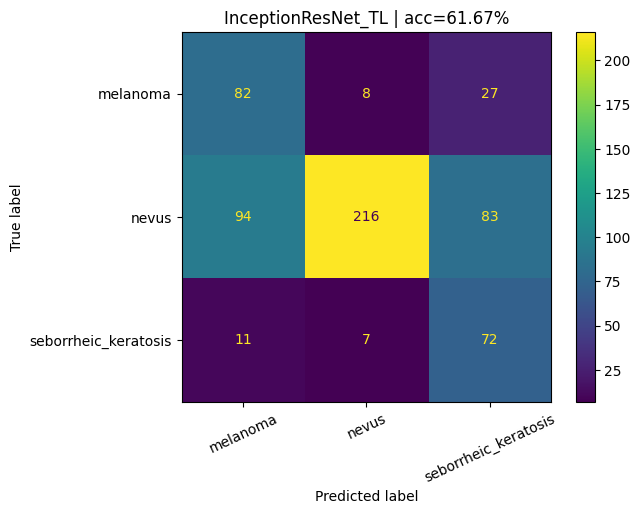

                      precision    recall  f1-score   support

            melanoma     0.4385    0.7009    0.5395       117
               nevus     0.9351    0.5496    0.6923       393
seborrheic_keratosis     0.3956    0.8000    0.5294        90

            accuracy                         0.6167       600
           macro avg     0.5897    0.6835    0.5871       600
        weighted avg     0.7573    0.6167    0.6381       600



In [ ]:
print("\n=== InceptionResNet_TL ===")
cm, acc = plot_cm_from_preds(all_preds['InceptionResNet_TL'], all_targs, VOCAB, title='InceptionResNet_TL', figsize=(5,5))

yhat = all_preds['InceptionResNet_TL'].argmax(axis=1)
print(classification_report(all_targs, yhat, target_names=VOCAB, digits=4))

The InceptionResNet_TL model reaches an accuracy of 61.83%, the lowest among the four, and shows a strongly biased behavior: it prioritizes detecting the minority classes at the cost of degrading overall performance.

For melanoma, it achieves the highest recall of all models (0.701) with 82 correct predictions, but with low precision (0.441) (F1=0.541). This indicates a high number of melanoma false positives, mainly due to a strong confusion of nevus as melanoma (93).

For nevus, the pattern is the opposite: precision is very high (0.935) but recall drops to 0.552 (F1=0.694). This reflects that when the model predicts nevus it is usually correct, but it fails to label many nevi as such, misclassifying them mainly as melanoma (93) and seborrheic_keratosis (83).

For seborrheic_keratosis, it obtains the highest recall (0.800) (72/90) but with low precision (0.396) (F1=0.529), indicating overprediction of this class.

Overall, the macro average (F1=0.588) confirms irregular performance across classes, and the weighted average (F1=0.640) is limited by the drop in total accuracy. This is consistent with a more “aggressive” decision strategy that improves melanoma sensitivity but considerably increases confusions with nevus.

---

Overall, the multiclass analysis shows a consistent pattern: all four models perform best on nevus, the majority class, while melanoma and seborrheic_keratosis account for most of the confusions.

The two ViT-based models provide the best overall balance in terms of accuracy and aggregated metrics, but they still show limited sensitivity for melanoma, with many melanomas being classified as nevus.

In contrast, EfficientNet_TL and InceptionResNet_TL increase melanoma recall (and also seborrheic_keratosis recall), but at the cost of a clear drop in accuracy and precision. This is mainly due to an increase in false positives and a noticeable degradation in nevus recognition.

Therefore, in a multiclass setting the main shared difficulty is separating melanoma from nevus, and the comparison reveals a trade-off between more “conservative” models (better overall performance) and more “aggressive” models (higher melanoma sensitivity but more overall errors).

To compare the models more reliably in a multiclass and imbalanced setting, we add two global metrics that complement our analysis: the Matthews Correlation Coefficient and Cohen's Kappa. Both are based on the information in the confusion matrix and help avoid interpretations dominated by the majority class.

* MCC (Matthews Correlation Coefficient). MCC measures the correlation between the true and predicted classes (generalized to multiclass) using the full confusion matrix. It is especially useful under class imbalance because it better reflects the overall quality of the classifier: values close to 1 indicate very consistent predictions, values around 0 indicate performance similar to random guessing, and negative values indicate behavior worse than random.

* Cohen's Kappa. Kappa measures the level of agreement between predictions and true labels, but it corrects for the agreement that could occur simply by chance given the class distribution. This is relevant when one class is much more frequent, because part of the accuracy may be explained by label proportions. High values indicate that the model provides real agreement beyond chance, while values close to 0 suggest that the observed agreement could be largely explained by the class distribution.

In [ ]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

def mcc_kappa_table(all_preds, targs, sort_by="mcc", ascending=False):
    rows = []
    for name, preds in all_preds.items():
        yhat = preds.argmax(axis=1)
        rows.append({
            "model": name,
            "mcc": matthews_corrcoef(targs, yhat),
            "kappa": cohen_kappa_score(targs, yhat),
        })
    df = pd.DataFrame(rows).sort_values(sort_by, ascending=ascending).reset_index(drop=True)
    return df

df_mcc_kappa = mcc_kappa_table(all_preds, targs, sort_by="mcc", ascending=False)
df_mcc_kappa

model       mcc     kappa
0      ViT_supervised  0.541968  0.540652
1       ViT_DINO_semi  0.528035  0.525343
2     EfficientNet_TL  0.449133  0.432068
3  InceptionResNet_TL  0.443990  0.402489

The MCC and Cohen’s Kappa values reinforce the conclusions obtained from the confusion matrix and the classification report. Both indicators summarize overall performance using the full confusion matrix and are less sensitive to class imbalance, showing that the Vision Transformer–based models achieve a more consistent agreement with the true labels. In particular, ViT_supervised obtains the best results (MCC = 0.542, Kappa = 0.541), followed by ViT_DINO_semi (MCC = 0.513, Kappa = 0.511), which suggests a more stable and reliable overall multiclass behavior.

In contrast, EfficientNet_TL and InceptionResNet_TL show lower values (MCC ≈ 0.45, Kappa ≈ 0.43 and 0.40), indicating reduced global consistency and a higher level of confusion between classes. This is consistent with their tendency to redistribute errors across categories, especially by increasing confusions with nevus, which lowers overall agreement despite specific improvements in recall for some classes. Overall, MCC and Kappa confirm that, from a robust multiclass perspective, the ViT models deliver the best global performance in this experiment.

## Binary Analysis

In this section, we reformulate the problem as a main clinical decision: “melanoma” vs “non-melanoma” (where “non-melanoma” groups nevus and seborrheic_keratosis). To do this, we treat melanoma as the positive class and use the model's assigned probability for melanoma as the score. This formulation allows us to evaluate performance using metrics specifically designed for threshold-based decisions, such as sensitivity and specificity, and to study the effect of changing the decision threshold on the balance between false negatives (missed melanomas) and false positives (benign lesions flagged as melanoma). We do this because, although the original problem is multiclass, in a screening/diagnostic context the priority is usually to control the risk of missing melanomas, and the binary approach makes it easier to define operating points aligned with clinical objectives (for example, setting a minimum sensitivity and measuring the resulting specificity).

### ROC Analysis

The ROC curve (Receiver Operating Characteristic) is a way to evaluate a binary classifier when the model outputs not only a class label but also a score/probability (in our case, the probability of melanoma). Instead of fixing a single threshold to decide “melanoma” vs “non-melanoma,” the ROC shows what happens as that threshold varies: for each threshold, we compute the true positive rate (TPR) and the false positive rate (FPR). By plotting TPR (y-axis) against FPR (x-axis), the curve describes the trade-off between detecting more melanomas (higher sensitivity) and, at the same time, increasing false alarms (higher FPR).

ROC-AUC (Area Under the Curve) summarizes this curve into a single number: it is the area under the ROC and measures the model's discrimination ability, meaning how well it separates positive cases (melanoma) from negative cases (non-melanoma) independently of the chosen threshold. An AUC of 0.5 corresponds to a classifier with no discriminative ability (similar to random guessing), while values close to 1 indicate an almost perfect separation.

We analyze ROC and ROC-AUC because they allow a stable comparison between models without depending on a specific threshold, and they provide a global view of binary performance before defining clinical operating points (thresholds) based on the desired balance between sensitivity and specificity.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = (targs == mel_idx).astype(int)

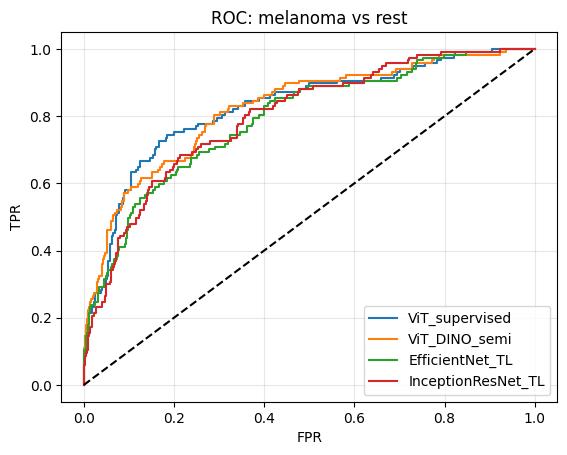

In [ ]:
plt.figure()
for name, preds in all_preds.items():
    y_score = preds[:, mel_idx]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC: melanoma vs rest")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
df_roc = pd.DataFrame([
    {"model": name, "roc_auc": roc_auc_score(y_true, preds[:, mel_idx])}
    for name, preds in all_preds.items()
]).sort_values("roc_auc", ascending=False)

df_roc

model   roc_auc
0      ViT_supervised  0.826795
1       ViT_DINO_semi  0.823910
3  InceptionResNet_TL  0.797597
2     EfficientNet_TL  0.791085

The ROC curve (melanoma vs the rest) shows a clear separation between the ViT-based models and the transfer learning CNN models. Visually, ViT_supervised and ViT_DINO_semi keep the curve closer to the upper-left corner across a large part of the range, especially for low and moderate FPR values, which indicates that they achieve a higher true positive rate for the same cost in false positives.

This observation is confirmed by the ROC-AUC values, where both ViT models are practically tied and lead the comparison (ViT_DINO_semi = 0.826989, ViT_supervised = 0.826795), reflecting a very similar overall discrimination ability that is independent of the threshold. Below them are InceptionResNet_TL (0.797508) and EfficientNet_TL (0.791244), whose curves generally lie beneath those of the ViTs, indicating a weaker separation between melanoma and non-melanoma.

Overall, both the ROC shape and the AUC suggest that the ViT models have the strongest ability to distinguish melanoma from the rest in this test set.

### PR Analysis

The Precision-Recall (PR) curve evaluates a binary classifier when the model outputs a score/probability for the positive class (here, melanoma). Unlike the ROC curve, the PR curve directly represents the trade-off between recall and precision as the decision threshold changes. For each threshold, the model produces a pair (recall, precision), and the curve shows how precision changes as we require the model to capture more positive cases.

We use it because, in imbalanced problems where the positive class is relatively less frequent, the PR curve is often more informative than ROC. In this setting, a small increase in false positives can strongly affect precision, and the PR curve reflects this effect more directly. Therefore, PR allows us to compare models in terms of how much precision is “paid” when recall is increased to detect melanoma. To summarize the curve with a single value, we use Average Precision (AP), which integrates precision-recall performance across all thresholds.

In [ ]:
y_true.mean()

np.float64(0.195)

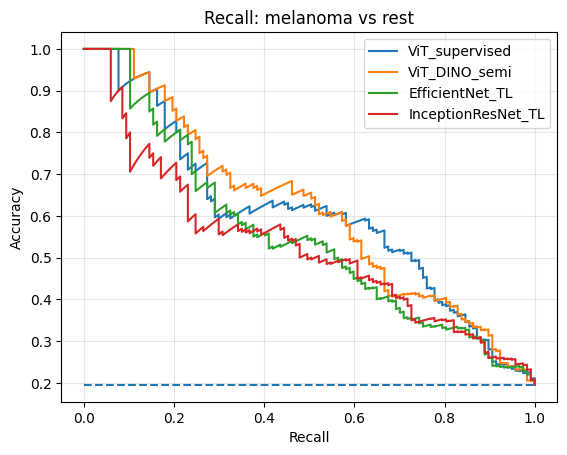

In [ ]:
from sklearn.metrics import precision_recall_curve

y_true = (targs == mel_idx).astype(int)

plt.figure()
for name, preds in all_preds.items():
    y_score = preds[:, mel_idx]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, label=name)

# Línea base (prevalencia de melanoma)
baseline = y_true.mean()
plt.hlines(baseline, 0, 1, linestyles="dashed")

plt.xlabel("Recall")
plt.ylabel("Accuracy")
plt.title("Recall: melanoma vs rest")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import average_precision_score

df_ap = pd.DataFrame([
    {"model": name, "ap": average_precision_score(y_true, preds[:, mel_idx])}
    for name, preds in all_preds.items()
]).sort_values("ap", ascending=False)

df_ap

model        ap
1       ViT_DINO_semi  0.612988
0      ViT_supervised  0.603922
2     EfficientNet_TL  0.552100
3  InceptionResNet_TL  0.528477

The Precision-Recall curve confirms the pattern observed in the ROC analysis, but it offers a more direct view of the cost in false positives when pushing for higher recall. In general, all curves lie clearly above the baseline (melanoma prevalence), which indicates that the models provide real predictive power. However, when forcing very high recall (close to 1), precision drops to low values, showing that capturing almost all melanomas implies accepting a substantial increase in false alarms.

In comparative terms, ViT_supervised maintains the highest curve across a large part of the range and achieves the highest Average Precision (AP = 0.6039), indicating the best overall balance between precision and recall across thresholds. ViT_DINO_semi is very close (AP = 0.5779) and remains competitive, although slightly lower across most of the range. Below them are EfficientNet_TL (AP = 0.5523) and InceptionResNet_TL (AP = 0.5282), whose curves tend to stay lower, especially at medium-to-high recall. This suggests that, to reach similar recall levels, they need to sacrifice more precision (i.e., they generate more false positives). Overall, the AP ranking places the two ViT models as the strongest options for the binary melanoma vs rest task, with ViT_supervised performing best under the most informative metric for imbalanced settings.

### Operating Points

An operating point is a specific choice of threshold on the melanoma score/probability that sets a particular operating mode for the binary classifier. Unlike the ROC and PR curves, which evaluate model behavior across all possible thresholds, this analysis focuses on how the system would perform in real conditions when it must make a concrete decision. Changing the threshold modifies the balance between false negatives and false positives, so we analyze threshold-dependent metrics:
* True Positive Rate (TPR): Measures the proportion of real melanomas that are detected.
$$TPR = \frac{TP}{TP+FN}$$
* True Negative Rate (TNR): Measures the proportion of non-melanomas that are correctly rejected.
$$PPV = \frac{TN}{TN+FP}$$
* Positive Predictive Value (PPV): Among all cases predicted as melanoma, the proportion that are truly melanoma.
$$PPV = \frac{TP}{TP+FP}$$
* Negative Predictive Value (NPV): Among all cases predicted as non-melanoma, the proportion that are truly non-melanoma.
$$PPV = \frac{TN}{TN+FN}$$

This approach is especially relevant for melanoma detection, because it is often necessary to operate under clinical or practical constraints, for example, setting a minimum TPR target to reduce the risk of missing melanomas, or setting a minimum TNR target to limit false alarms, and then comparing models based on the performance achieved under those criteria.

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

def best_thr_for_tnr(y_true, y_score, target_tnr=0.90):
    """
    Finds a threshold such that TNR >= target_tnr, and among those,
    picks the one that maximizes TPR.
    """
    fpr, tpr, thr = roc_curve(y_true, y_score)
    tnr = 1 - fpr  # True Negative Rate

    # remove inf threshold (often the first element)
    mask = np.isfinite(thr)
    thr, tnr, tpr = thr[mask], tnr[mask], tpr[mask]

    ok = np.where(tnr >= target_tnr)[0]
    if len(ok) == 0:
        return None

    best = ok[np.argmax(tpr[ok])]
    return float(thr[best])

def best_thr_for_tpr(y_true, y_score, target_tpr=0.95):
    """
    Finds a threshold such that TPR >= target_tpr, and among those,
    picks the one that maximizes TNR.
    """
    fpr, tpr, thr = roc_curve(y_true, y_score)
    tnr = 1 - fpr  # True Negative Rate

    # remove inf threshold (often the first element)
    mask = np.isfinite(thr)
    thr, tpr, tnr = thr[mask], tpr[mask], tnr[mask]

    ok = np.where(tpr >= target_tpr)[0]
    if len(ok) == 0:
        return None

    best = ok[np.argmax(tnr[ok])]
    return float(thr[best])

def op_counts(y_true, y_score, thr):
    """
    Returns:
      TPR: True Positive Rate  = TP / (TP + FN)
      TNR: True Negative Rate  = TN / (TN + FP)
      PPV: Positive Predictive Value (precision) = TP / (TP + FP)
      NPV: Negative Predictive Value             = TN / (TN + FN)
      plus TP, FP, TN, FN counts
    """
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tpr = tp / (tp + fn + 1e-12)
    tnr = tn / (tn + fp + 1e-12)
    ppv = tp / (tp + fp + 1e-12)
    npv = tn / (tn + fn + 1e-12)

    return tpr, tnr, ppv, npv, int(tp), int(fp), int(tn), int(fn)


We first analyze the models by fixing a target TPR (i.e., requiring the system to detect at least X% of melanomas).

In [ ]:
targets_tpr = [0.95, 0.90, 0.85, 0.80]  # ajusta los que quieras

for tgt in targets_tpr:
    rows = []
    for name, preds in all_preds.items():
        y_score = preds[:, mel_idx]
        thr = best_thr_for_tpr(y_true, y_score, target_tpr=tgt)
        if thr is None:
            rows.append({"model": name, "target_TPR": tgt, "thr": None})
            continue

        tpr, tnr, ppv, npv, tp, fp, tn, fn = op_counts(y_true, y_score, thr)
        rows.append({
            "model": name,
            "thr": thr,
            "TPR": tpr,
            "TNR": tnr,
            "PPV": ppv,
            "NPV": npv,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn
        })

    df = pd.DataFrame(rows).sort_values("PPV", ascending=False).reset_index(drop=True)

    print(f"\n=== Operating point: TPR >= {tgt:.2f} ===")
    display(df.style.format({
        "thr": "{:.6f}",
        "TPR": "{:.3f}", "TNR": "{:.3f}", "PPV": "{:.3f}", "NPV": "{:.3f}"
    }))



=== Operating point: TPR >= 0.95 ===



=== Operating point: TPR >= 0.90 ===



=== Operating point: TPR >= 0.85 ===



=== Operating point: TPR >= 0.80 ===


These results clearly illustrate the trade-off when setting different TPR targets (melanoma detection) and how the cost in false positives and PPV changes as this requirement is relaxed.

With TPR ≥ 0.95, all models operate at practically the same detection point (TP = 112, FN = 5), so the real comparison is based on TNR / FP / PPV. In this regime, InceptionResNet_TL performs best, with the highest TNR (0.329) and the lowest number of FP (324), which leads to the highest PPV (0.257). Even so, PPV is low for all models (≈ 0.235-0.257), showing that requiring such a high TPR forces very low thresholds and produces many false alarms.

When lowering the target to TPR ≥ 0.90, the effect is noticeable: the number of false positives decreases and both TNR and PPV increase across all models. Here, ViT_DINO_semi stands out, achieving the best balance with TNR = 0.522, FP = 231, and the highest PPV (0.315) while maintaining TPR = 0.906 (FN = 11). The other models remain below, especially ViT_supervised, which keeps the same TPR but with worse TNR (0.439) and PPV (0.281).

At TPR ≥ 0.85, the two ViT models are the most consistent: ViT_DINO_semi and ViT_supervised are almost tied with TNR ≈ 0.61 and PPV ≈ 0.347-0.348, while EfficientNet and InceptionResNet show lower TNR and PPV, meaning more false alarms for the same level of melanoma detection.

Finally, at TPR ≥ 0.80, we reach a setting where the system becomes more “selective”: PPV improves clearly (≈ 0.33-0.40) and FP decreases substantially. Again, ViT_DINO_semi performs best in this mode, with TNR = 0.712, FP = 139, and PPV = 0.403, outperforming the rest. Overall, the pattern across the four tables is that as the TPR target is relaxed (from 0.95 to 0.80), models gain in TNR and PPV and reduce FP, and that the ViT models—especially ViT_DINO_semi—tend to offer the best trade-off in these intermediate, moderately demanding regimes, while InceptionResNet_TL only stands out when the TPR requirement is extremely high.

Now we move to fixing a TNR target (i.e., “I want to correctly reject X% of non-melanoma cases”).

In [ ]:
targets_tnr = [0.90, 0.92, 0.95, 0.97]

for tgt in targets_tnr:
    rows = []
    for name, preds in all_preds.items():
        y_score = preds[:, mel_idx]
        thr = best_thr_for_tnr(y_true, y_score, target_tnr=tgt)
        if thr is None:
            rows.append({"model": name, "target_TNR": tgt, "thr": None})
            continue

        tpr, tnr, ppv, npv, tp, fp, tn, fn = op_counts(y_true, y_score, thr)
        rows.append({
            "model": name,
            "thr": thr,
            "TPR": tpr,
            "TNR": tnr,
            "PPV": ppv,
            "NPV": npv,
            "TP": tp, "FP": fp, "TN": tn, "FN": fn
        })

    df = pd.DataFrame(rows).sort_values("TPR", ascending=False).reset_index(drop=True)

    print(f"\n=== Operating point: TNR >= {tgt:.2f} ===")
    display(df.style.format({
        "thr": "{:.6f}",
        "TPR": "{:.3f}", "TNR": "{:.3f}", "PPV": "{:.3f}", "NPV": "{:.3f}"
    }))


=== Operating point: TNR >= 0.90 ===



=== Operating point: TNR >= 0.92 ===



=== Operating point: TNR >= 0.95 ===



=== Operating point: TNR >= 0.97 ===


These results analyze the opposite situation to the TPR sweep: here we set different TNR targets (false-positive control) and observe how much TPR can be maintained and how many melanomas are missed (FN). In general, as the TNR target becomes stricter (0.90 → 0.97), false positives decrease and PPV increases, but TPR drops noticeably, increasing FN. In other words, operating with fewer false alarms implies missing more melanomas.

At TNR ≥ 0.90, the ViT models are the best at preserving melanoma detection: ViT_supervised achieves TPR = 0.581 with 68 TP and 49 FN, and also the best PPV (0.607) with only 44 FP. ViT_DINO_semi is very similar (TPR = 0.581, PPV = 0.591, FP = 47). In contrast, EfficientNet_TL and InceptionResNet_TL keep comparable TNR, but sacrifice TPR (0.496 and 0.470) and accumulate more FN (59 and 62), indicating weaker detection under the same level of false-alarm control.

When moving to TNR ≥ 0.92, the pattern remains: the ViTs stay on top (TPR 0.538 and 0.521) and also show the best PPV (0.624 and 0.629) with a low number of FP (38 and 36). EfficientNet and InceptionResNet drop further in TPR (0.410–0.436) and increase FN substantially (66–69), making them less suitable if the goal is to preserve melanoma detection.

At TNR ≥ 0.95, there is a strong TPR decrease across all models, but ViT_DINO_semi stands out as the best compromise: it maintains TPR = 0.393 (46 TP, 71 FN) with the highest PPV (0.667) and 23 FP. The rest fall to TPR ≈ 0.30–0.33 with slightly lower PPV, showing that under such strict false-positive constraints, melanoma detection becomes much more limited.

Finally, at TNR ≥ 0.97, the system becomes very conservative: FP drop to about 12–14 and PPV increases (≈ 0.675–0.727), but TPR falls to about 0.23–0.31, meaning most melanomas are missed (FN 81–90). In this regime, ViT_DINO_semi keeps the highest TPR (0.308) with a high PPV (0.720), while ViT_supervised achieves the best PPV (0.727) at the cost of a lower TPR (0.274).

As a conclusion, when prioritizing a high TNR (limiting false positives), the ViT models preserve melanoma detection best at TNR = 0.90–0.92, while for very demanding TNR targets (≥ 0.95) the TPR of all models drops substantially. This reinforces that choosing an operating point must carefully balance the clinical cost of increasing false negatives against the operational benefit of reducing false positives.

---

Overall, the two experiments (fixing TPR and fixing TNR) show the same fundamental trade-off: detecting more melanomas requires accepting more false alarms, and if false alarms are reduced aggressively, melanomas are missed. When a very high TPR is enforced (≥ 0.95), all models generate a very large number of false positives and precision is low; in that regime, InceptionResNet_TL is the model that best controls false alarms. However, when the TPR target is relaxed to more realistic values (≈ 0.90-0.80), the ViT models—especially ViT_DINO_semi—provide the best balance, because they clearly improve precision and reduce false positives while keeping melanoma detection still high. Conversely, when a high TNR is required (≥ 0.90-0.92), the ViT models also maintain melanoma detection better than the others; and if the constraint becomes very strict (≥ 0.95-0.97), all models become too conservative and miss a large proportion of melanomas. In summary, the ViT models are the most consistent at realistic operating points, and the final threshold should be chosen based on the desired balance between “not missing melanomas” and “not overwhelming the system with false alarms”.

### False Negative Analysis

In this final section, we perform a visual analysis of melanoma false negatives (FN), i.e., cases where the true label is melanoma but the model predicts another class. This type of error is especially critical in a clinical context, since it corresponds to missed melanomas. The goal is to manually inspect these examples to identify recurring difficulty patterns (low contrast, diffuse borders, small lesions, artifacts, similarity to nevi, etc.) and to better understand why the model fails and in which scenarios it is less reliable.

In [ ]:
def fn_melanoma(preds, targs, files, top_n=20):
    yhat = preds.argmax(axis=1)
    df = pd.DataFrame({
        "path": [str(p) for p in files],
        "true": [VOCAB[i] for i in targs],
        "pred": [VOCAB[i] for i in yhat],
        "conf": preds.max(axis=1),
        "p_melanoma": preds[:, mel_idx],
    })
    fn = df[(df.true=="melanoma") & (df.pred!="melanoma")].copy()
    return fn.sort_values("conf", ascending=False).head(top_n)

import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import PILImage

def show_fn_images(fn_df, title="", n=12, cols=4):
    n = min(n, len(fn_df))
    if n == 0:
        print("No hay FN para mostrar.")
        return

    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    for i in range(n):
        r = fn_df.iloc[i]
        img = PILImage.create(r["path"])
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"T: melanoma | P: {r['pred']}\nconf={r['conf']:.2f} pMel={r['p_melanoma']:.2f}",
            fontsize=10
        )

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



ViT_supervised | FN melanoma total: 58


pred      conf  p_melanoma  \
45                 nevus  0.938907    0.050022   
5                  nevus  0.922970    0.067821   
53  seborrheic_keratosis  0.900416    0.049524   
98                 nevus  0.897083    0.072815   
4                  nevus  0.892909    0.029412   
60                 nevus  0.889029    0.069227   
14                 nevus  0.884724    0.041582   
6                  nevus  0.879742    0.056405   
48                 nevus  0.838373    0.144413   
87                 nevus  0.829632    0.155655   
88                 nevus  0.804280    0.168916   
90                 nevus  0.802443    0.181958   
92                 nevus  0.787100    0.164462   
0   seborrheic_keratosis  0.786406    0.044758   
27                 nevus  0.775444    0.117017   

                                                            path  
45  /content/dataset/skin-lesions/test/melanoma/ISIC_0014059.jpg  
5   /content/dataset/skin-lesions/test/melanoma/ISIC_0012758.jpg  
53  /content/dataset/skin-lesions/test/melanoma/ISIC_0014186.jpg  
98  /content/dataset/skin-lesions/test/melanoma/ISIC_0015046.jpg  
4   /content/dataset/skin-lesions/test/melanoma/ISIC_0012425.jpg  
60  /content/dataset/skin-lesions/test/melanoma/ISIC_0014288.jpg  
14  /content/dataset/skin-lesions/test/melanoma/ISIC_0013414.jpg  
6   /content/dataset/skin-lesions/test/melanoma/ISIC_0012989.jpg  
48  /content/dataset/skin-lesions/test/melanoma/ISIC_0014110.jpg  
87  /content/dataset/skin-lesions/test/melanoma/ISIC_0014826.jpg  
88  /content/dataset/skin-lesions/test/melanoma/ISIC_0014862.jpg  
90  /content/dataset/skin-lesions/test/melanoma/ISIC_0014883.jpg  
92  /content/dataset/skin-lesions/test/melanoma/ISIC_0014928.jpg  
0   /content/dataset/skin-lesions/test/melanoma/ISIC_0012258.jpg  
27  /content/dataset/skin-lesions/test/melanoma/ISIC_0013696.jpg

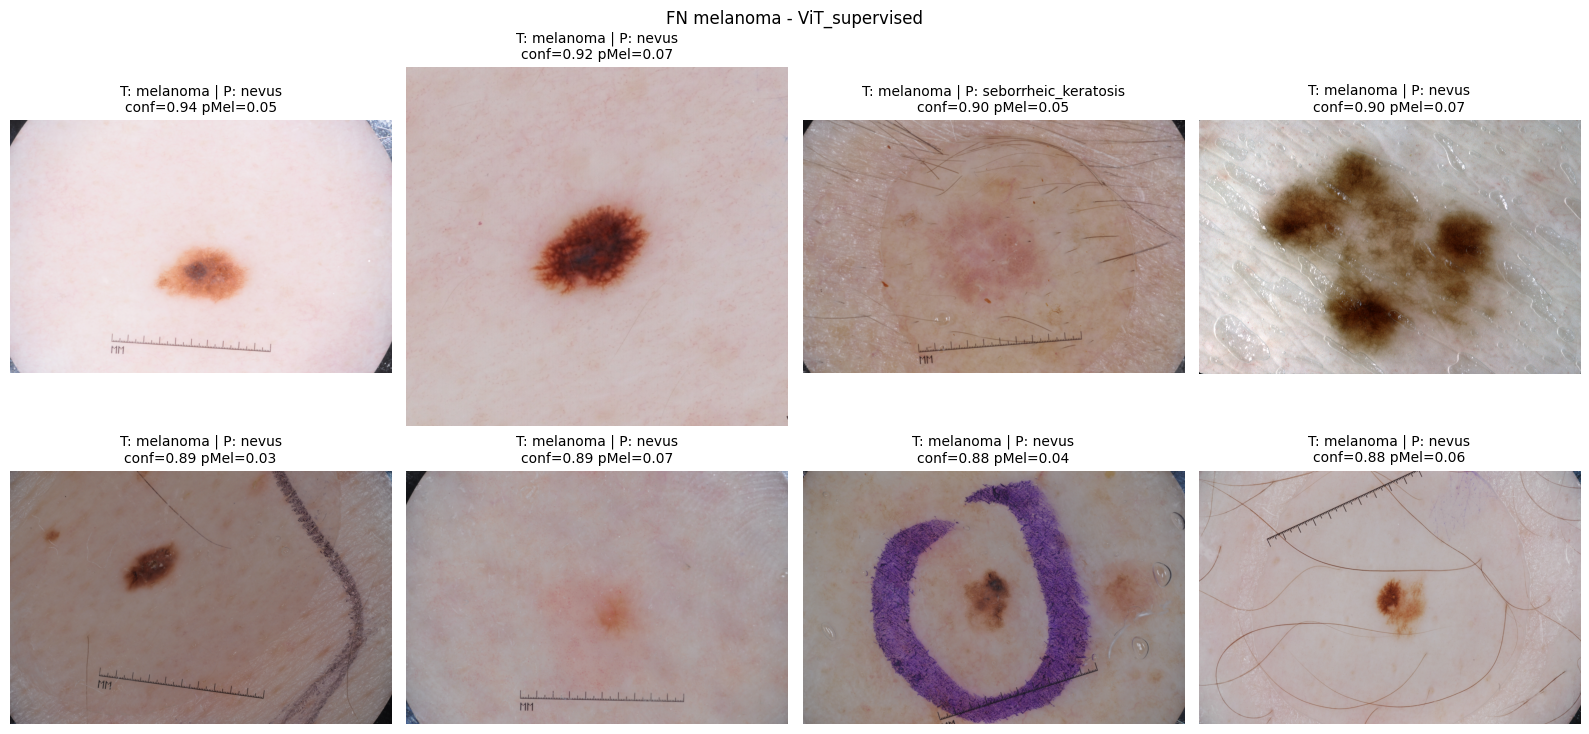

In [ ]:
name = "ViT_supervised"
preds, targs = all_preds[name], all_targs

fn = fn_melanoma(preds, targs, test_files, top_n=15)
print(f"\n{name} | FN melanoma total:", ((targs==mel_idx) & (preds.argmax(1)!=mel_idx)).sum())
display(fn[["pred","conf","p_melanoma","path"]])
show_fn_images(fn, title=f"FN melanoma - {name}", n=8)

For ViT_supervised, we observe 58 melanoma false negatives, and the dominant pattern is confusion of melanoma as nevus (with an occasional case predicted as seborrheic_keratosis). This confirms that the model's main difficulty is not detecting “lesion vs no lesion,” but rather correctly discriminating between pigmented lesions with similar appearance.

In addition, several of these false negatives occur with high confidence (values close to 0.9) and with very low melanoma probability (p_melanoma typically < 0.1). This suggests that these are not borderline cases where the model is uncertain, but examples where the model clearly favors a benign class, which is especially critical in a screening context.

Visually, many FNs correspond to relatively small lesions, low-contrast lesions, or lesions with features that can resemble a nevus. Artifacts also appear (hair, measurement rulers, marks), which may influence the model's decision and contribute to these confusions.


ViT_DINO_semi | FN melanoma total: 59


pred      conf  p_melanoma  \
45                  nevus  0.933649    0.053705   
79   seborrheic_keratosis  0.925448    0.023997   
11   seborrheic_keratosis  0.910557    0.019689   
6                   nevus  0.856735    0.055659   
113                 nevus  0.855931    0.108184   
48                  nevus  0.836486    0.148952   
53   seborrheic_keratosis  0.807509    0.063218   
30                  nevus  0.798572    0.179320   
4                   nevus  0.770833    0.104372   
5                   nevus  0.760159    0.228967   
87                  nevus  0.744918    0.215728   
93                  nevus  0.737527    0.155807   
92                  nevus  0.735446    0.150440   
44                  nevus  0.725131    0.075464   
75                  nevus  0.715391    0.219893   

                                                             path  
45   /content/dataset/skin-lesions/test/melanoma/ISIC_0014059.jpg  
79   /content/dataset/skin-lesions/test/melanoma/ISIC_0014695.jpg  
11   /content/dataset/skin-lesions/test/melanoma/ISIC_0013321.jpg  
6    /content/dataset/skin-lesions/test/melanoma/ISIC_0012989.jpg  
113  /content/dataset/skin-lesions/test/melanoma/ISIC_0015193.jpg  
48   /content/dataset/skin-lesions/test/melanoma/ISIC_0014110.jpg  
53   /content/dataset/skin-lesions/test/melanoma/ISIC_0014186.jpg  
30   /content/dataset/skin-lesions/test/melanoma/ISIC_0013766.jpg  
4    /content/dataset/skin-lesions/test/melanoma/ISIC_0012425.jpg  
5    /content/dataset/skin-lesions/test/melanoma/ISIC_0012758.jpg  
87   /content/dataset/skin-lesions/test/melanoma/ISIC_0014826.jpg  
93   /content/dataset/skin-lesions/test/melanoma/ISIC_0014932.jpg  
92   /content/dataset/skin-lesions/test/melanoma/ISIC_0014928.jpg  
44   /content/dataset/skin-lesions/test/melanoma/ISIC_0014027.jpg  
75   /content/dataset/skin-lesions/test/melanoma/ISIC_0014548.jpg

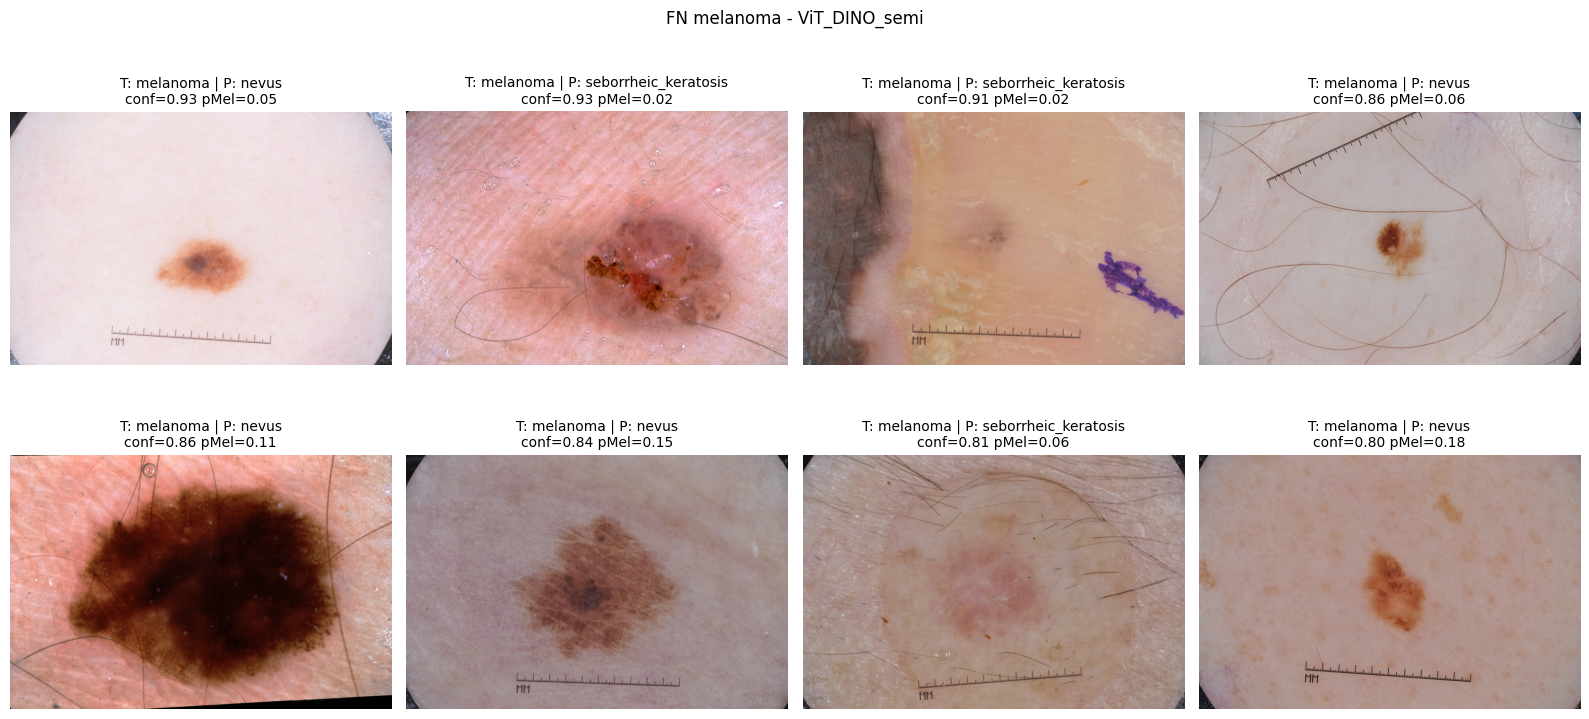

In [ ]:
name = "ViT_DINO_semi"
preds, targs = all_preds[name], all_targs

fn = fn_melanoma(preds, targs, test_files, top_n=15)
print(f"\n{name} | FN melanoma total:", ((targs==mel_idx) & (preds.argmax(1)!=mel_idx)).sum())
display(fn[["pred","conf","p_melanoma","path"]])
show_fn_images(fn, title=f"FN melanoma - {name}", n=8)

Similarly, ViT_DINO_semi shows a high number of melanoma false negatives (59), and the dominant confusion remains melanoma → nevus. The most noticeable difference compared to ViT_supervised is that here we more often see FNs classified as seborrheic_keratosis among the “top” cases, suggesting that the model also falls into this second type of confusion when the lesion looks lighter/pinkish or has a texture compatible with keratosis.

The most concerning pattern also repeats: several FNs appear with high confidence (≈ 0.91-0.93) and extremely low p_melanoma (≈ 0.02-0.05), indicating wrong but very confident decisions. In other words, the model not only fails, but does so with a clear margin, increasing the risk that these cases would not be “recovered” if an argmax-type decision rule is used.

At a visual level, the shown examples include multiple images with distracting elements (ruler, hair, ink/marks) and lesions with ambiguous appearance (some with very weak pigmentation or low contrast), which seems to push the model toward benign explanations (nevus) or toward seborrheic_keratosis in the more “atypical” cases.


EfficientNet_TL | FN melanoma total: 49


pred      conf  p_melanoma  \
39   seborrheic_keratosis  0.878177    0.078173   
92                  nevus  0.860075    0.109795   
53   seborrheic_keratosis  0.859778    0.095234   
41   seborrheic_keratosis  0.846018    0.096751   
73   seborrheic_keratosis  0.829775    0.088399   
22   seborrheic_keratosis  0.828611    0.100425   
5                   nevus  0.767607    0.211789   
27                  nevus  0.765033    0.114999   
10                  nevus  0.759907    0.154233   
84   seborrheic_keratosis  0.757098    0.096399   
90                  nevus  0.727813    0.228943   
79                  nevus  0.718140    0.188476   
56   seborrheic_keratosis  0.711503    0.246945   
24   seborrheic_keratosis  0.703174    0.068098   
111  seborrheic_keratosis  0.699366    0.223083   

                                                             path  
39   /content/dataset/skin-lesions/test/melanoma/ISIC_0013925.jpg  
92   /content/dataset/skin-lesions/test/melanoma/ISIC_0014928.jpg  
53   /content/dataset/skin-lesions/test/melanoma/ISIC_0014186.jpg  
41   /content/dataset/skin-lesions/test/melanoma/ISIC_0013953.jpg  
73   /content/dataset/skin-lesions/test/melanoma/ISIC_0014542.jpg  
22   /content/dataset/skin-lesions/test/melanoma/ISIC_0013588.jpg  
5    /content/dataset/skin-lesions/test/melanoma/ISIC_0012758.jpg  
27   /content/dataset/skin-lesions/test/melanoma/ISIC_0013696.jpg  
10   /content/dataset/skin-lesions/test/melanoma/ISIC_0013277.jpg  
84   /content/dataset/skin-lesions/test/melanoma/ISIC_0014784.jpg  
90   /content/dataset/skin-lesions/test/melanoma/ISIC_0014883.jpg  
79   /content/dataset/skin-lesions/test/melanoma/ISIC_0014695.jpg  
56   /content/dataset/skin-lesions/test/melanoma/ISIC_0014233.jpg  
24   /content/dataset/skin-lesions/test/melanoma/ISIC_0013617.jpg  
111  /content/dataset/skin-lesions/test/melanoma/ISIC_0015180.jpg

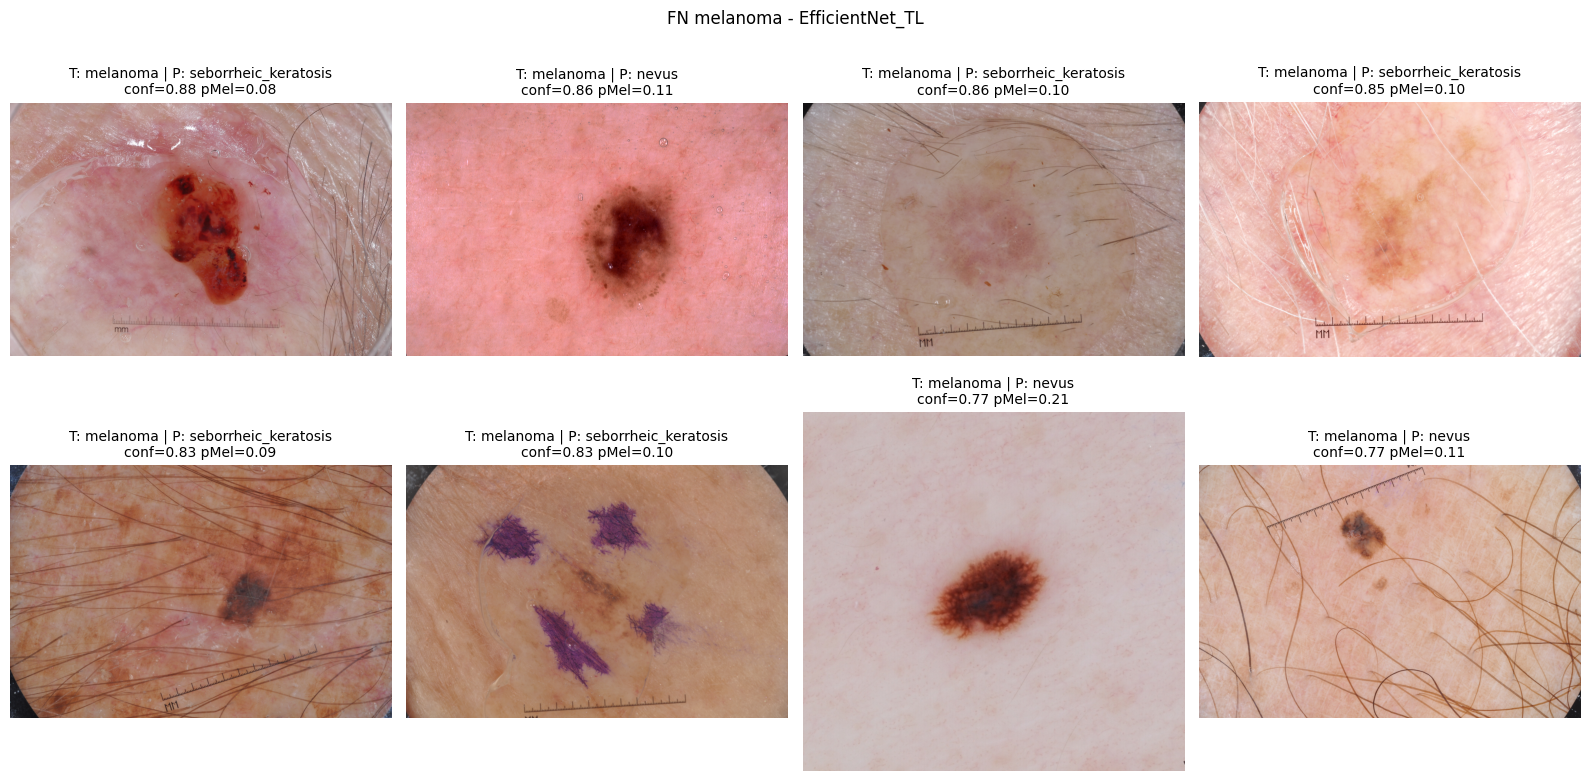

In [ ]:
name = "EfficientNet_TL"
preds, targs = all_preds[name], all_targs

fn = fn_melanoma(preds, targs, test_files, top_n=15)
print(f"\n{name} | FN melanoma total:", ((targs==mel_idx) & (preds.argmax(1)!=mel_idx)).sum())
display(fn[["pred","conf","p_melanoma","path"]])
show_fn_images(fn, title=f"FN melanoma - {name}", n=8)

Compared to the ViT models, EfficientNet_TL still produces relevant melanoma false negatives, although the total decreases to 49. The main difference here is the type of confusion: among the FNs, melanoma → seborrheic_keratosis is much more common than melanoma → nevus, suggesting that this model tends to explain some melanomas as keratosis when the lesion is lighter, reddish, or shows a compatible texture.

In these FNs, confidence remains relatively high (≈ 0.83-0.88) while melanoma probability stays low (≈ 0.08-0.11 in several of the most extreme cases), indicating that some errors are also made with substantial confidence. In the analyzed images, there are several examples with lightly pigmented or diffuse-looking lesions, and some include artifacts (hair, ruler, marks), which seem to push the model toward seborrheic_keratosis.

Overall, EfficientNet_TL reduces the number of FNs compared to the ViTs, but its error pattern shifts: it does not only confuse with nevus, but redirects many melanomas toward seborrheic_keratosis.


InceptionResNet_TL | FN melanoma total: 35


pred      conf  p_melanoma  \
66  seborrheic_keratosis  0.912828    0.025295   
43  seborrheic_keratosis  0.876693    0.084257   
53  seborrheic_keratosis  0.765126    0.106289   
32  seborrheic_keratosis  0.764844    0.160673   
13  seborrheic_keratosis  0.764512    0.152837   
45                 nevus  0.756435    0.224367   
71  seborrheic_keratosis  0.745375    0.112645   
56  seborrheic_keratosis  0.741226    0.144714   
44  seborrheic_keratosis  0.705794    0.111700   
28  seborrheic_keratosis  0.701724    0.155433   
39  seborrheic_keratosis  0.673184    0.279736   
37  seborrheic_keratosis  0.657560    0.242287   
14                 nevus  0.654113    0.307664   
6                  nevus  0.650495    0.308324   
0   seborrheic_keratosis  0.605208    0.147806   

                                                            path  
66  /content/dataset/skin-lesions/test/melanoma/ISIC_0014434.jpg  
43  /content/dataset/skin-lesions/test/melanoma/ISIC_0013988.jpg  
53  /content/dataset/skin-lesions/test/melanoma/ISIC_0014186.jpg  
32  /content/dataset/skin-lesions/test/melanoma/ISIC_0013813.jpg  
13  /content/dataset/skin-lesions/test/melanoma/ISIC_0013411.jpg  
45  /content/dataset/skin-lesions/test/melanoma/ISIC_0014059.jpg  
71  /content/dataset/skin-lesions/test/melanoma/ISIC_0014513.jpg  
56  /content/dataset/skin-lesions/test/melanoma/ISIC_0014233.jpg  
44  /content/dataset/skin-lesions/test/melanoma/ISIC_0014027.jpg  
28  /content/dataset/skin-lesions/test/melanoma/ISIC_0013733.jpg  
39  /content/dataset/skin-lesions/test/melanoma/ISIC_0013925.jpg  
37  /content/dataset/skin-lesions/test/melanoma/ISIC_0013908.jpg  
14  /content/dataset/skin-lesions/test/melanoma/ISIC_0013414.jpg  
6   /content/dataset/skin-lesions/test/melanoma/ISIC_0012989.jpg  
0   /content/dataset/skin-lesions/test/melanoma/ISIC_0012258.jpg

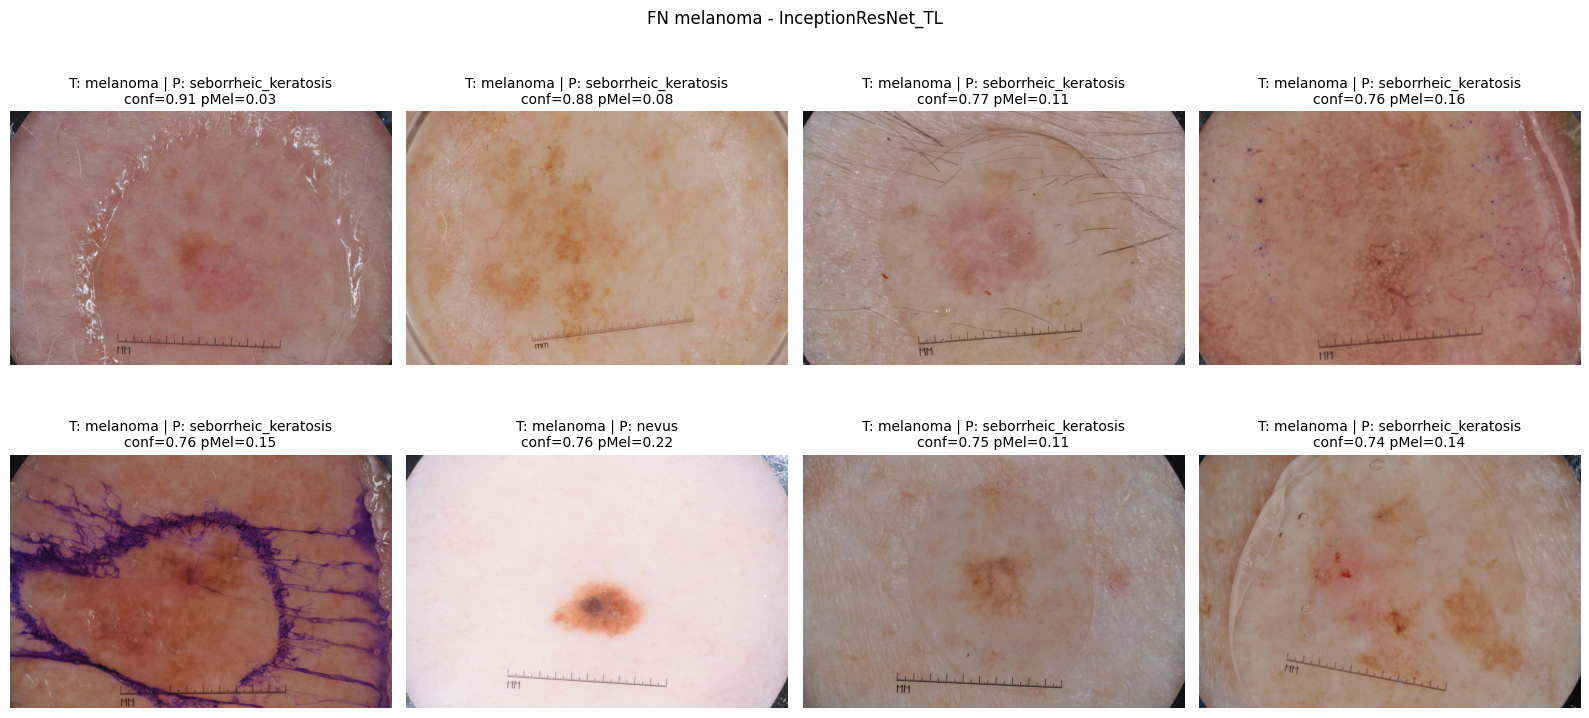

In [ ]:
name = "InceptionResNet_TL"
preds, targs = all_preds[name], all_targs

fn = fn_melanoma(preds, targs, test_files, top_n=15)
print(f"\n{name} | FN melanoma total:", ((targs==mel_idx) & (preds.argmax(1)!=mel_idx)).sum())
display(fn[["pred","conf","p_melanoma","path"]])
show_fn_images(fn, title=f"FN melanoma - {name}", n=8)

As with EfficientNet_TL, the dominant error pattern in InceptionResNet_TL is confusion of melanoma as seborrheic_keratosis, and this effect is even more pronounced: in the list of “top” FNs, almost all wrong predictions are seborrheic_keratosis, with few cases labeled as nevus. This matches what is seen in the mosaic, where melanomas appear less pigmented or more “diffuse/erythematous,” which the model tends to explain as keratosis.

The positive aspect is that this model substantially reduces the total number of false negatives: 35 FNs, the lowest among the four. Even so, several of these FNs have high confidence (for example, conf ≈ 0.91) and very low melanoma probability (pMel ≈ 0.03-0.08 in the most extreme cases), meaning that some melanomas are rejected with high certainty.

In summary, InceptionResNet_TL seems to “move” the main error from nevus toward seborrheic_keratosis and, at the same time, achieves fewer total FNs. However, when it fails, it often does so on melanomas with a less typical appearance and with a fairly confident decision toward keratosis.

# Conclusion

In this work, several deep learning approaches were compared for skin cancer detection in a multiclass setting (melanoma, nevus, and seborrheic keratosis) and, later, in a clinically more aligned binary setting (melanoma vs the rest). The multiclass analysis showed that Vision Transformer-based models provide the most consistent overall performance, mainly due to their strong behavior on the majority class (nevus), while transfer learning CNN models tend to introduce more inter-class confusions and reduce overall accuracy. Robust imbalance-aware metrics (MCC and Kappa) supported this conclusion by ranking the ViT models as those with the highest overall multiclass agreement.

When reformulating the problem as binary, the ROC and Precision-Recall curves confirmed that the ViT models have the best overall discrimination ability (AUC values essentially tied and higher AP), with ViT_supervised achieving the best AP and ViT_DINO_semi very close behind. However, the operating point analysis showed that the choice of threshold strongly determines practical behavior: requiring a very high TPR leads to a large increase in false positives and reduces precision, while requiring a very high TNR makes the system too conservative and significantly increases false negatives. Under more realistic operating regimes (moderate TPR or TNR = 0.90-0.92), the ViT models tend to offer the best balance, although InceptionResNet_TL stands out when an extremely high TPR is imposed, due to better false-positive control at that point.

Finally, the visual analysis of false negatives showed that the most frequent error in the ViT models is confusing melanoma with nevus, while in EfficientNet and InceptionResNet the dominant confusion is with seborrheic keratosis. In addition, high-confidence false negatives appear across all models, which highlights the need to operate with carefully chosen thresholds and to interpret the system as a decision-support tool. Overall, the results suggest that ViT models are the most solid option for global performance and binary discrimination, but that clinical deployment should focus on defining an appropriate operating point that explicitly balances the cost of false negatives against false positives.